##### Creation dun model le plus rapide pour predire si il ya un risk dattaque cardiaque pour une personne 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score , confusion_matrix 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("cleaned_merged_heart_dataset.csv")


#  set 1 = male, 0 = female.
sex = {1 : "male" , 0 : "female"}
#cp: Chest pain type. => traduction = type de douleur thoracique
cp = {0 : "Typical angina", 1 : "Atypical angina", 2 : "Non-anginal pain", 3 : "Asymptomatic"}

#fbs: Fasting blood sugar. => traduction = glycémie à jeune
fbs = {1 : ">120 mg/dl" , 0 : "<120 mg/dl"}

#restecg: Resting electrocardiographic results.  => traduction = résultats électrocardiographiques au repos
restecg = {0 : "Normal", 1 : "ST-T wave abnormality", 2 : "Left ventricular hypertrophy"}
#exang: Exercise induced angina.  => traduction = angine induite par l'exercice 
exang = {1 : "Yes", 0 : "No"}
#slope: Slope of the peak exercise ST segment.=> traduction = pente du segment ST de l'exercice de pointe 
slope = {0 : "Upsloping", 1 : "Flat", 2 : "Downsloping"}
#thal: Thalassemia types.  => traduction = types de thalassémie
thal = {1 : "Normal", 2 : "Fixed defect", 3 : "Reversible defect"}
#target: Outcome variable (heart attack risk). 
target = {1 : "more chance of heart attack", 0 : "less chance of heart attack"}





(1888, 14)


<Axes: >

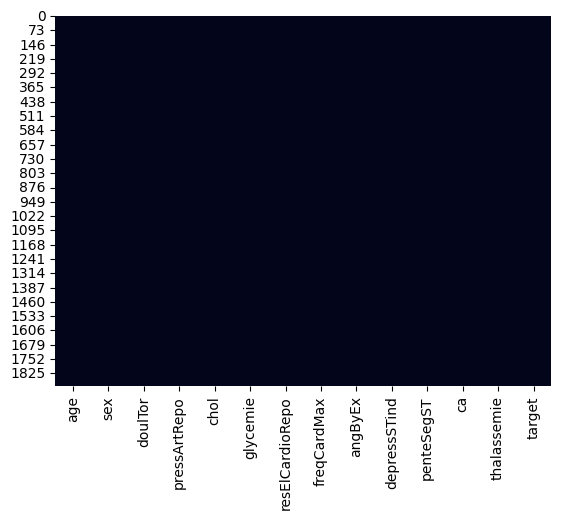

In [3]:


#print the dataset shape
print(data.shape)
#plot the NaN values with a heatmap
sns.heatmap(data.isnull(), cbar=False)

#####  HeatMap pour visualise les donnees manquantes:

aucune donnee manquante vu que j'ai upload un fichier cleaned

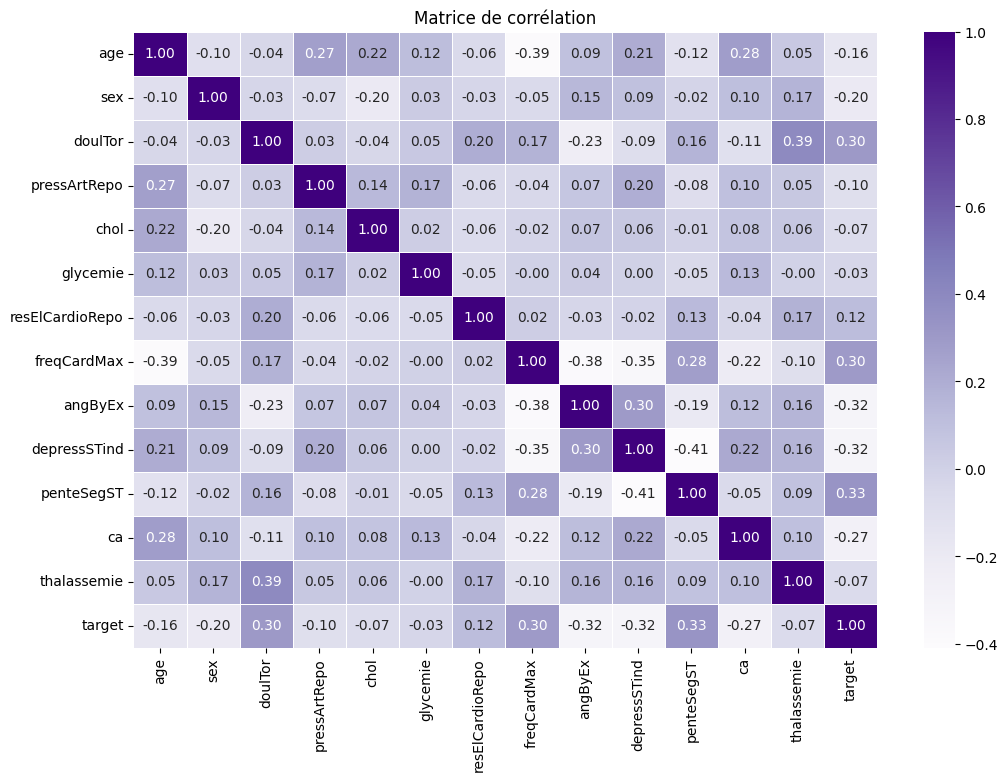

In [4]:
# Calcul de la matrice de corrélation
corr_matrix = data.corr()

# Affichage de la heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Purples', fmt=".2f", linewidths=0.5)
plt.title("Matrice de corrélation")
plt.show()

<Axes: xlabel='age', ylabel='Count'>

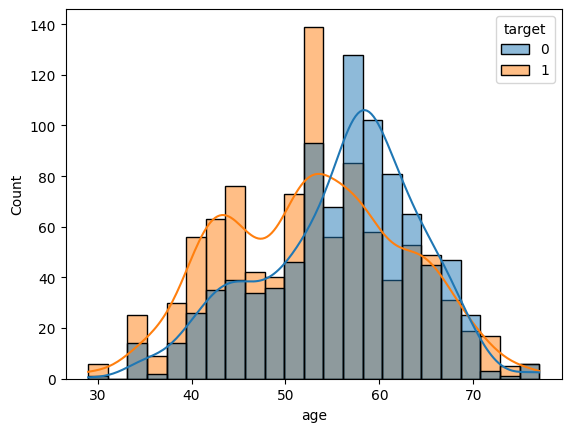

In [5]:
#print the histogram of the age column selon la mortalite 

sns.histplot(data=data, x='age', hue='target', kde=True)


<Axes: xlabel='doulTor', ylabel='Count'>

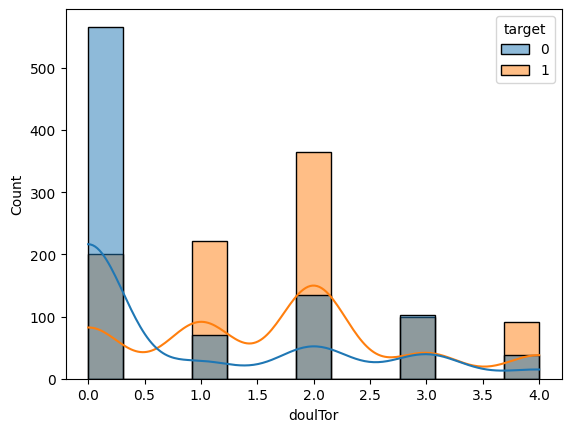

In [6]:
#print the histogram of the   

sns.histplot(data=data, x='doulTor', hue='target', kde=True)

sur ce graphique on vois bien que les etat d'angine normal ont  oin de risque dattack cardiaque 

In [7]:
# using pca to reduce the dimensionality of the dataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#standardize the data
# we drop the target column because it is the column we want to predict
# on standardise les colomn qui ont des valeurs non numeriques mais categoriques
# exemple la colonne 
scaler = StandardScaler()
X = data.drop('target', axis=1)
y = data['target']
X = scaler.fit_transform(X)

#apply pca
pca = PCA()
X_pca = pca.fit_transform(X)



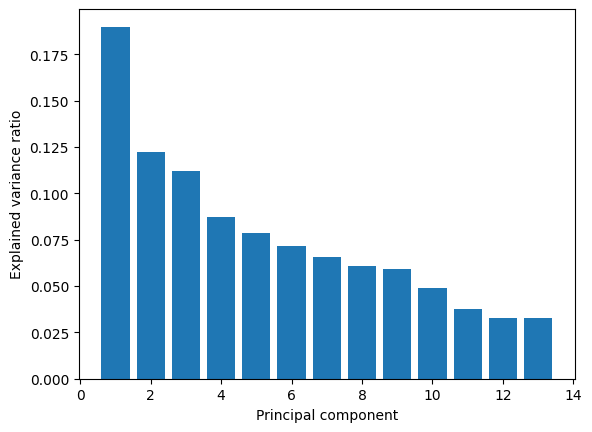

In [8]:
pca.explained_variance_ratio_

# afficher un plot pour chaque composante 
plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.xlabel('Principal component')
plt.ylabel('Explained variance ratio')
plt.show()

ici chaque composante explique une partie de la variance de la dataset

il n ya pas de composante qui explique une grande partie  a la fois , on pourra reduire 
la dimensionalite en enlevant les composantes qui expliquent une faible partie de la variance

In [9]:
# trouver le nombre de feature qui montrent 90% de linformation (variance)

cumsum = 0
n_components = 0
for var in pca.explained_variance_ratio_:
    cumsum += var
    n_components += 1
    if cumsum >= 0.9:
        break
print(n_components,"/", len(pca.explained_variance_ratio_))



11 / 13


In [10]:
# dispatcher les donnees en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_pca = X_pca[:, :n_components]
# donnee avec PCA 
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.3, random_state=42)

In [11]:
# utilisation de l'algorithme RandomForestClassifier pour predire le risk 


cls = RandomForestClassifier(n_estimators=100, random_state=42)
# entraienr le modele
cls.fit(X_train, y_train)

y_pred = cls.predict(X_test)

## apres utilisation des PCA 
cls_pca = RandomForestClassifier(n_estimators=100, random_state=42)

cls_pca.fit(X_train_pca, y_train_pca)

y_pred_pca = cls_pca.predict(X_test_pca)


Without PCA
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       286
           1       0.97      0.96      0.97       281

    accuracy                           0.97       567
   macro avg       0.97      0.97      0.97       567
weighted avg       0.97      0.97      0.97       567

With PCA
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       286
           1       0.93      0.96      0.95       281

    accuracy                           0.95       567
   macro avg       0.95      0.95      0.95       567
weighted avg       0.95      0.95      0.95       567



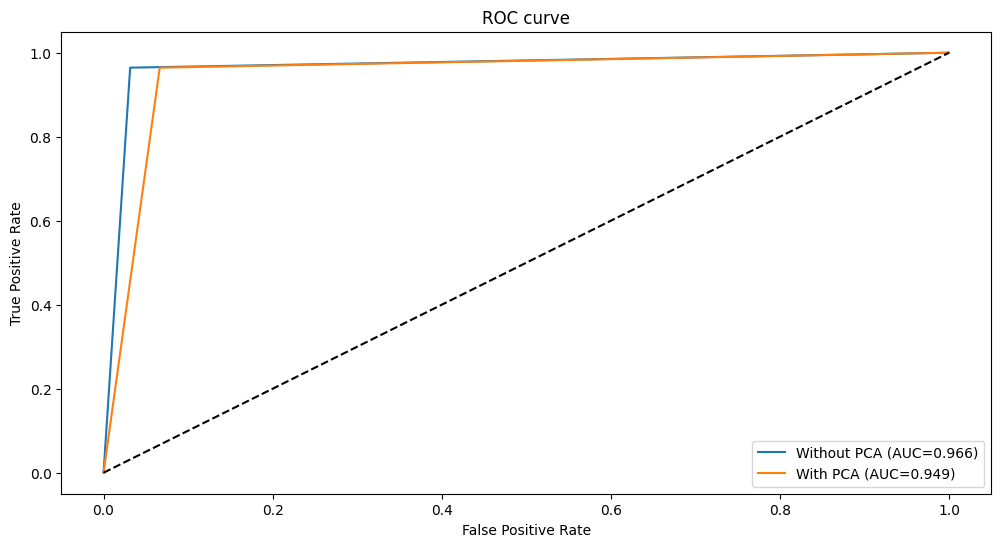

In [12]:



import numpy as np
from sklearn.metrics import auc, classification_report, roc_curve
# Calculate metrics and AUC and ROC for both models




test_fpr, test_tpr, _ = roc_curve(y_test.values, y_pred)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

test_fpr_pca, test_tpr_pca, _ = roc_curve(y_test_pca.values, y_pred_pca)
test_auc_pca = np.round(auc(test_fpr_pca, test_tpr_pca), 3)


# Classification report
result = classification_report(y_test, y_pred)
result_pca = classification_report(y_test_pca, y_pred_pca)

print ('Without PCA')
print(result)
print ('With PCA')
print(result_pca)
# plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_fpr, test_tpr, label=f'Without PCA (AUC={test_auc})')
plt.plot(test_fpr_pca, test_tpr_pca, label=f'With PCA (AUC={test_auc_pca})')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.show()


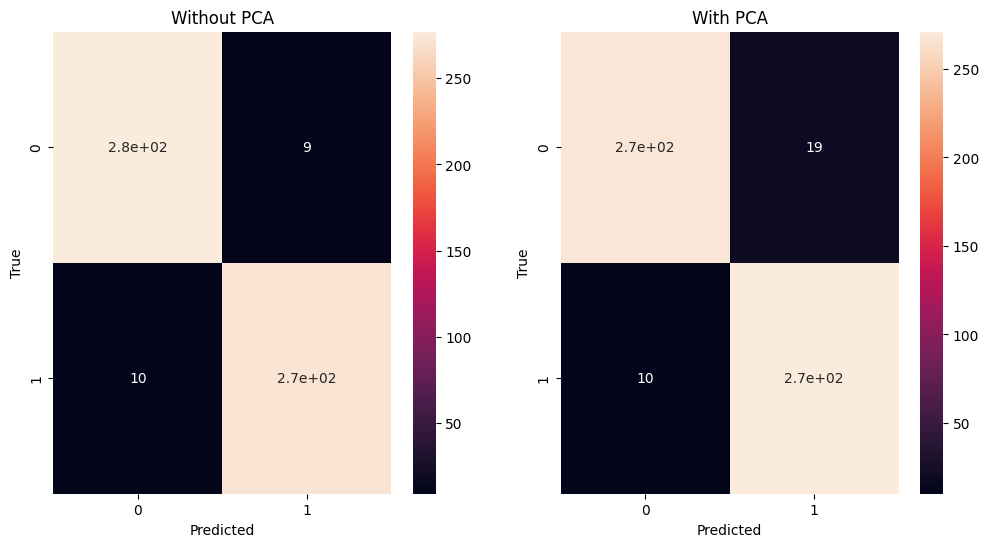

In [13]:

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
# faire deux heatmap dans une figure pour et sans PCA
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(cm, annot=True, ax=ax[0])
ax[0].set_title('Without PCA')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')
cm_pca = confusion_matrix(y_test_pca, y_pred_pca)
sns.heatmap(cm_pca, annot=True, ax=ax[1])
ax[1].set_title('With PCA')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('True')
plt.show()



grace au PCA on a reussi a diminuer le nombre de feature a donner a notre model sans pour autant alterer les resultats de prediction  car chaque composante assure un pourcentage d'information sauvegarder

